In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import skew
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## **데이터 로드**

kaggle data 활용하여 방문자수 예측 알고리즘 시험적용  
(출처: https://www.kaggle.com/competitions/recruit-restaurant-visitor-forecasting)  


In [2]:
air_visit_data = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/air_visit_data.csv.zip')
air_store_info = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/air_store_info.csv.zip')
hpg_store_info = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/hpg_store_info.csv.zip')
air_reserve = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/air_reserve.csv.zip')
hpg_reserve = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/hpg_reserve.csv.zip')
store_id_relation = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/store_id_relation.csv.zip')
date_info = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/date_info.csv.zip')
weather_data = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/WeatherData.csv.zip')
area_name_mapping = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/area_name_mapping.zip')

#test_data input
sample_submission = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/sample_submission.csv.zip')

In [3]:
air_visit_data.head(5)

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [4]:
air_store_info.shape

(829, 5)

In [5]:
hpg_store_info.shape

(4690, 5)

### 결측치 확인

In [6]:
print('*** air_reserve ***\n', air_reserve.isnull().sum())
print('*** hpg_reserve ***\n', hpg_reserve.isnull().sum())
print('*** store_id_relation ***\n', store_id_relation.isnull().sum())
print('*** air_info ***\n', air_store_info.isnull().sum())

*** air_reserve ***
 air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64
*** hpg_reserve ***
 hpg_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64
*** store_id_relation ***
 air_store_id    0
hpg_store_id    0
dtype: int64
*** air_info ***
 air_store_id      0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
dtype: int64


In [7]:
print('*** hpg_info ***\n', hpg_store_info.isnull().sum())
print('*** visit_data ***\n', air_visit_data.isnull().sum())
print('*** date_info ***\n', date_info.isnull().sum())
print('*** weather_data ***\n', weather_data.isnull().sum())
print('*** area_name_mapping ***\n', area_name_mapping.isnull().sum())

*** hpg_info ***
 hpg_store_id      0
hpg_genre_name    0
hpg_area_name     0
latitude          0
longitude         0
dtype: int64
*** visit_data ***
 air_store_id    0
visit_date      0
visitors        0
dtype: int64
*** date_info ***
 calendar_date    0
day_of_week      0
holiday_flg      0
dtype: int64
*** weather_data ***
 area_name                 0
calendar_date             0
precipitation          3623
avg_temperature        4152
total_snowfall        28911
deepest_snowfall      28404
hours_sunlight         7265
avg_wind_speed         4245
avg_vapor_pressure    23282
avg_humidity          23282
avg_sea_pressure      23265
avg_local_pressure    23265
solar_radiation       26884
cloud_cover           25850
high_temperature       4152
low_temperature        4152
dtype: int64
*** area_name_mapping ***
 air_area_name    0
station_id       0
dtype: int64


## **데이터 전처리**

In [8]:
print("air의 예약된 식당 수: ", len(air_reserve['air_store_id'].unique()))
air_reserve.head()

air의 예약된 식당 수:  314


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [9]:
print("air에 정보가 있는 식당 수: ", len(air_store_info['air_store_id'].unique()))

air에 정보가 있는 식당 수:  829


In [10]:
print("hpg의 예약된 식당 수: ", len(hpg_reserve['hpg_store_id'].unique()))
hpg_reserve.head()

hpg의 예약된 식당 수:  13325


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [11]:
print("hpg에 정보가 있는 식당 수: ", len(hpg_store_info['hpg_store_id'].unique()))

hpg에 정보가 있는 식당 수:  4690


## **data info**

In [12]:
print("air와 hpg가 맵핑되어 있는 수: ", len(store_id_relation))
store_id_relation.head()

air와 hpg가 맵핑되어 있는 수:  150


,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [13]:
#df_map을 info를 모아놓은 dataframe으로 생성
#hpg 데이터 기준으로 air에서의 아이디가 뭔지 column 생성
df_map = pd.merge(hpg_store_info, store_id_relation, on = 'hpg_store_id', how = 'outer')
df_map.tail(5)

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,air_store_id
4772,hpg_265bd3fe806f8b6e,NaN,NaN,NaN,NaN,air_f96765e800907c77
4773,hpg_ef517ab154f66a8e,NaN,NaN,NaN,NaN,air_09661c0f3259cc04
4774,hpg_0cc0abae3a8b52de,NaN,NaN,NaN,NaN,air_b8925441167c3152
4775,hpg_1004356dc8ab69ec,NaN,NaN,NaN,NaN,air_6607fe3671242ce3
4776,hpg_df22bf146d2c7e19,NaN,NaN,NaN,NaN,air_ccd19a5bc5573ae5


In [14]:
df_map.head(5)

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,air_store_id
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN


In [15]:
df_map.shape

(4777, 6)

#### hpg에 등록된 store 중 air에도 ID가 있는 가게는 4777개일까?

In [16]:
df_map.iloc[4680:4695]
#모든 hpg info의 가게가 air아이디가 있는건 아님

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,air_store_id
4680,hpg_cde530deaa97c31c,Amusement bar,Hokkaidō Sapporo-shi Minami 4 Jōnishi,43.055047,141.353236,NaN
4681,hpg_a74709cf53c76924,Amusement bar,Hokkaidō Sapporo-shi Minami 4 Jōnishi,43.055047,141.353236,NaN
4682,hpg_3c41f028563beac3,Amusement bar,Hokkaidō Sapporo-shi Minami 4 Jōnishi,43.055047,141.353236,air_fc477473134e9ae5
4683,hpg_e60322667e14b99c,Amusement bar,Hokkaidō Sapporo-shi Minami 4 Jōnishi,43.055047,141.353236,NaN
4684,hpg_68637e2b90172cd3,Sichuan food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453,NaN
4685,hpg_c6ed353a48c7c93e,Sichuan food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453,NaN
4686,hpg_a58d2423360b2fb4,Sichuan food,Tōkyō-to Minato-ku Roppongi,35.666137,139.733978,NaN
4687,hpg_d2021704076cdd70,Shanghai food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453,NaN
4688,hpg_602472570d65e219,Spain/Mediterranean cuisine,Tōkyō-to Toshima-ku None,35.730068,139.711742,NaN
4689,hpg_11801306ce8bfb4f,Udon/Soba,Osaka Prefecture Osaka None,34.701519,135.498859,NaN


In [17]:
df_map_final = df_map.loc[(df_map['air_store_id'].isna()==False) & (df_map['hpg_store_id'].isna()==False)]
df_map_final

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,air_store_id
98,hpg_cac091abfcee2a85,Japanese style,Tōkyō-to Chūō-ku Ginza,35.668600,139.763043,air_2aab19554f91ff82
150,hpg_e87d00be48cd91c6,Japanese style,Tōkyō-to Sumida-ku Tachibana,35.704960,139.828642,air_258ad2619d7bff9a
178,hpg_03795a62e1c5f1c3,Japanese style,Hiroshima-ken Hiroshima-shi Hondōri,34.392106,132.461914,air_c47aa7493b15f297
216,hpg_51fab1683266cd55,Japanese style,Ōsaka-fu Ōsaka-shi Shinsaibashisuji,34.669514,135.501425,air_96005f79124e12bf
351,hpg_9668001cf2b8dc74,Japanese style,Tōkyō-to Taitō-ku None,35.711353,139.782684,air_f2c5a1f24279c531
...,...,...,...,...,...,...
4772,hpg_265bd3fe806f8b6e,NaN,NaN,NaN,NaN,air_f96765e800907c77
4773,hpg_ef517ab154f66a8e,NaN,NaN,NaN,NaN,air_09661c0f3259cc04
4774,hpg_0cc0abae3a8b52de,NaN,NaN,NaN,NaN,air_b8925441167c3152
4775,hpg_1004356dc8ab69ec,NaN,NaN,NaN,NaN,air_6607fe3671242ce3


In [18]:
print("hpg중 air에도 아이디가 있는 가게: ", len(df_map_final['hpg_store_id'].unique()))

hpg중 air에도 아이디가 있는 가게:  150


#### hpg와 air 둘 다 ID가 있는 hpg info data는 150개

In [19]:
#air_store_info 데이터까지 hpg_store_info 데이터에 합쳐준다(air_store_id 기준으로)
df_final = pd.merge(df_map, air_store_info, on = 'air_store_id', how = 'outer')
df_final.shape

(5456, 10)

In [20]:
df_final.head(5)

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_x,longitude_x,air_store_id,air_genre_name,air_area_name,latitude_y,longitude_y
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN


In [21]:
df_final.iloc[4773:4782]
df_final.reset_index(drop=True)

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_x,longitude_x,air_store_id,air_genre_name,air_area_name,latitude_y,longitude_y
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5451,NaN,NaN,NaN,NaN,NaN,air_6b65745d432fd77f,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
5452,NaN,NaN,NaN,NaN,NaN,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
5453,NaN,NaN,NaN,NaN,NaN,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
5454,NaN,NaN,NaN,NaN,NaN,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051


In [22]:
df_final.shape

(5456, 10)

In [23]:
df_final.to_csv("store_count_outer.csv")

### 등록된 가게는 ***총 5456개***

### reserve data도 훑어보기  
- air  
- hpg  

In [24]:
#df_air = air_reserve + air_store_info (store id 정보가 있는 경우만 reserve에서 살려둠)
df_air = pd.merge(air_reserve, air_store_info, on = 'air_store_id')
print("air 예약 수: ", len(air_reserve))
print("air 예약 중 가게 정보 있는 수: ", len(df_air))
print(df_air.shape)
df_air.head(3)

air 예약 수:  92378
air 예약 중 가게 정보 있는 수:  92378
(92378, 8)


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [25]:
#df_hpg = hpg_reserve + hpg_store_info (store id 정보가 있는 경우만 reserve에서 살려둠)
df_hpg = pd.merge(hpg_reserve, hpg_store_info, on = 'hpg_store_id')
print("hpg 예약 수: ", len(hpg_reserve))
print("hpg 예약 중 가게 정보 있는 수: ", len(df_hpg))
print(df_hpg.shape)
df_hpg.head(3)

hpg 예약 수:  2000320
hpg 예약 중 가게 정보 있는 수:  871308
(871308, 8)


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
1,hpg_dac72789163a3f47,2016-01-02 12:00:00,2016-01-01 20:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
2,hpg_dac72789163a3f47,2016-01-03 19:00:00,2016-01-02 15:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698


### column name 공통되게 변경
air_store_id, hpg_store_id > **id**   
air_genre_name, hpg_genre_name > **genre**   
air_area_name, hpg_area_name > **area_name**
   
**df_air_nc, df_hpg_nc로 각각 정의** 하여 concat한 data > **mixed_df** 로 생성

In [26]:
df_air_nc = df_air.rename(columns = {"air_store_id":"id", "air_genre_name":"genre", "air_area_name": "area_name"}, inplace = False)
df_hpg_nc = df_hpg.rename(columns = {"hpg_store_id":"id", "hpg_genre_name":"genre", "hpg_area_name": "area_name"}, inplace = False)
mixed_df = pd.concat([df_air_nc, df_hpg_nc])
mixed_df.reset_index(drop=True)
mixed_df

,id,visit_datetime,reserve_datetime,reserve_visitors,genre,area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
...,...,...,...,...,...,...,...,...
871303,hpg_e106ddef2b137959,2017-04-24 18:00:00,2017-04-20 14:00:00,8,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619
871304,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,14,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619
871305,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,15,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619
871306,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-10 17:00:00,18,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619


In [27]:
#visit_datetime(년-월-일-시간) 데이터를 년-월-일로 변경
df_ymd = mixed_df.copy()
df_ymd['visit_date'] = df_ymd['visit_datetime'].str.slice(start=0, stop=10)
df_ymd

,id,visit_datetime,reserve_datetime,reserve_visitors,genre,area_name,latitude,longitude,visit_date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-01
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-01
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-02
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-02
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-08
...,...,...,...,...,...,...,...,...,...
871303,hpg_e106ddef2b137959,2017-04-24 18:00:00,2017-04-20 14:00:00,8,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24
871304,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,14,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24
871305,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,15,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24
871306,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-10 17:00:00,18,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24


In [28]:
#같은 날, 같은 식당의 reserve_visitors 합치기
merged_df = df_ymd.groupby(by=['visit_date', 'id', 'genre','area_name','latitude','longitude'], as_index=False).sum()
merged_df.iloc[60:70]

C:\Users\piai\AppData\Local\Temp\ipykernel_15752\2154066644.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_df = df_ymd.groupby(by=['visit_date', 'id', 'genre','area_name','latitude','longitude'], as_index=False).sum()


,visit_date,id,genre,area_name,latitude,longitude,reserve_visitors
60,2016-01-01,hpg_ea38f0f5b6ff6091,Japanese style,Tōkyō-to Chōfu-shi Fujimichō,35.664161,139.540969,2
61,2016-01-01,hpg_f23b00c038f70720,Japanese style,Shizuoka-ken Numazu-shi Yanagisawa,35.143507,138.824721,4
62,2016-01-01,hpg_f52ca09c98a38e07,International cuisine,Tōkyō-to Machida-shi Nakamachi,35.549670,139.448494,3
63,2016-01-01,hpg_f6117f6d2533237f,Grilled meat,Fukuoka-ken Fukuoka-shi Daimyō,33.586969,130.392801,2
64,2016-01-01,hpg_f802d9079d5b1af3,Japanese style,Fukuoka-ken Fukuoka-shi Minamishō,33.576379,130.339313,2
65,2016-01-01,hpg_f92222c61d0adb11,International cuisine,Niigata-ken Niigata-shi Yoneyama,37.909809,139.062170,5
66,2016-01-02,air_2b8b29ddfd35018e,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,6
67,2016-01-02,air_3bb99a1fe0583897,Izakaya,Miyagi-ken Sendai-shi Kamisugi,38.269076,140.870403,4
68,2016-01-02,air_6b15edd1b4fbb96a,Italian/French,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,11
69,2016-01-02,air_789466e488705c93,Izakaya,Fukuoka-ken Kurume-shi Jōnanmachi,33.319286,130.508374,67


In [29]:
#요일, holiday flag column 추가하기
date_info.head(2)

with_day_df = pd.merge(merged_df, date_info,left_on='visit_date',right_on='calendar_date')
with_day_df = with_day_df.drop(['calendar_date'], axis = 1)
with_day_df.head(3)

,visit_date,id,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg
0,2016-01-01,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,3,Friday,1
1,2016-01-01,air_db4b38ebe7a7ceff,Dining bar,Ōsaka-fu Ōsaka-shi Shinmachi,34.676231,135.486059,9,Friday,1
2,2016-01-01,air_db80363d35f10926,Dining bar,Hokkaidō Asahikawa-shi 6 Jōdōri,43.770635,142.364819,5,Friday,1


In [30]:
#air_visit_data 이용해서 워크인, 노쇼 확인
air_visit_data.head(4)

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22


In [31]:
check_no_show_df = pd.merge(air_visit_data, with_day_df, left_on = ['air_store_id', 'visit_date'],right_on=['id','visit_date'])
check_no_show_df2 = check_no_show_df.drop(['id','latitude','longitude', 'genre','area_name','day_of_week','holiday_flg'], axis = 1)
check_no_show_df2

#merge의 기본값은 inner, air_visit_data에 있는 가게만 나옴

,air_store_id,visit_date,visitors,reserve_visitors
0,air_35512c42db0868da,2016-02-27,6,12
1,air_ee3a01f0c71a769f,2016-01-04,61,2
2,air_ee3a01f0c71a769f,2016-01-08,21,3
3,air_ee3a01f0c71a769f,2016-01-09,57,25
4,air_ee3a01f0c71a769f,2016-01-10,32,5
...,...,...,...,...
28059,air_754ae581ad80cc9f,2017-04-14,3,2
28060,air_754ae581ad80cc9f,2017-04-15,39,20
28061,air_754ae581ad80cc9f,2017-04-19,6,6
28062,air_754ae581ad80cc9f,2017-04-22,47,28


In [32]:
#예약인원과 실제 방문 고객 수 차이가 크기 때문에 예약 내용은 신경 안씀
#air_store_id, id값은 같으므로 id drop
visitor_df=check_no_show_df.drop(['id'], axis=1)
visitor_df.head(3)

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg
0,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to Musashino-shi Midorichō,35.717784,139.56626,12,Saturday,0
1,air_ee3a01f0c71a769f,2016-01-04,61,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.72594,2,Monday,0
2,air_ee3a01f0c71a769f,2016-01-08,21,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.72594,3,Friday,0


In [33]:
#genre 종류 확인
#visitor_df['genre'].unique()
visitor_df['genre'].value_counts(ascending=True)

Asian                              1
International cuisine              3
Karaoke/Party                     43
Other                            248
Creative cuisine                 331
Bar/Cocktail                     426
Okonomiyaki/Monja/Teppanyaki     932
Western food                     950
Cafe/Sweets                     1290
Yakiniku/Korean food            1508
Japanese food                   3076
Dining bar                      3406
Italian/French                  6071
Izakaya                         9779
Name: genre, dtype: int64

In [34]:
#genre 통합: Asian > other, International cuisine > other
genre_df = visitor_df.copy()
genre_df['genre'] = genre_df['genre'].replace('Asian', 'Other')
genre_df['genre'] = genre_df['genre'].replace('International cuisine', 'Other')
genre_df['genre'].value_counts(ascending=True)

Karaoke/Party                     43
Other                            252
Creative cuisine                 331
Bar/Cocktail                     426
Okonomiyaki/Monja/Teppanyaki     932
Western food                     950
Cafe/Sweets                     1290
Yakiniku/Korean food            1508
Japanese food                   3076
Dining bar                      3406
Italian/French                  6071
Izakaya                         9779
Name: genre, dtype: int64

In [35]:
#area_name에 none 있는지 확인
genre_df[genre_df['area_name'].isna()==True]

#없음

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg


In [36]:
#area_name에 none 있는지 확인
print(len(genre_df['area_name'].unique()))

# 동의 종류가 너무 다양해서 시를 기준으로 사용
si_df = genre_df.copy()
si_df['area_name'] = genre_df['area_name'].str.split(' ').str[0]
si_df['area_name'].value_counts(ascending=True)

71


Miyagi-ken        740
Niigata-ken      1025
Shizuoka-ken     1827
Ōsaka-fu         2039
Hiroshima-ken    2317
Hyōgo-ken        2415
Hokkaidō         3448
Fukuoka-ken      4382
Tōkyō-to         9871
Name: area_name, dtype: int64

In [37]:
area_df = si_df
area_df

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg
0,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0
1,air_ee3a01f0c71a769f,2016-01-04,61,Cafe/Sweets,Shizuoka-ken,34.710895,137.725940,2,Monday,0
2,air_ee3a01f0c71a769f,2016-01-08,21,Cafe/Sweets,Shizuoka-ken,34.710895,137.725940,3,Friday,0
3,air_ee3a01f0c71a769f,2016-01-09,57,Cafe/Sweets,Shizuoka-ken,34.710895,137.725940,25,Saturday,0
4,air_ee3a01f0c71a769f,2016-01-10,32,Cafe/Sweets,Shizuoka-ken,34.710895,137.725940,5,Sunday,0
...,...,...,...,...,...,...,...,...,...,...
28059,air_754ae581ad80cc9f,2017-04-14,3,Izakaya,Niigata-ken,37.874223,138.971940,2,Friday,0
28060,air_754ae581ad80cc9f,2017-04-15,39,Izakaya,Niigata-ken,37.874223,138.971940,20,Saturday,0
28061,air_754ae581ad80cc9f,2017-04-19,6,Izakaya,Niigata-ken,37.874223,138.971940,6,Wednesday,0
28062,air_754ae581ad80cc9f,2017-04-22,47,Izakaya,Niigata-ken,37.874223,138.971940,28,Saturday,0


### 최종 데이터셋의 그래프 일자별 정렬 및 시계열 그래프 찍어보기

In [38]:
#1. visit_date는 datetime type인가?
area_df.info()
#date_time 맞음

#2. visit_date 기준으로 정렬하자
area_df = area_df.sort_values('visit_date')
area_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28064 entries, 0 to 28063
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   air_store_id      28064 non-null  object 
 1   visit_date        28064 non-null  object 
 2   visitors          28064 non-null  int64  
 3   genre             28064 non-null  object 
 4   area_name         28064 non-null  object 
 5   latitude          28064 non-null  float64
 6   longitude         28064 non-null  float64
 7   reserve_visitors  28064 non-null  int64  
 8   day_of_week       28064 non-null  object 
 9   holiday_flg       28064 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.4+ MB


,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg
25255,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1
13176,air_877f79706adbfb06,2016-01-01,3,Japanese food,Tōkyō-to,35.658068,139.751599,3,Friday,1
9563,air_db80363d35f10926,2016-01-01,8,Dining bar,Hokkaidō,43.770635,142.364819,5,Friday,1
5849,air_6b15edd1b4fbb96a,2016-01-02,96,Italian/French,Shizuoka-ken,34.710895,137.725940,11,Saturday,1
14202,air_2b8b29ddfd35018e,2016-01-02,28,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken,34.386244,132.455018,6,Saturday,1
...,...,...,...,...,...,...,...,...,...,...
17702,air_63a750d8b4b6a976,2017-04-22,46,Italian/French,Fukuoka-ken,33.589216,130.392813,17,Saturday,0
5148,air_4d21676ed11f0bac,2017-04-22,33,Izakaya,Hiroshima-ken,34.386244,132.455018,27,Saturday,0
12446,air_dea0655f96947922,2017-04-22,64,Dining bar,Ōsaka-fu,34.705362,135.510025,20,Saturday,0
22432,air_83db5aff8f50478e,2017-04-22,4,Italian/French,Tōkyō-to,35.658068,139.751599,2,Saturday,0


### 날씨데이터만 안합친 최종 데이터셋: area_df

In [39]:
#weather data의 리셋이 필요할 경우 활용할 셀
weather_data = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/WeatherData.csv.zip')

In [40]:
#area_df에 weather data 합치기
weather_data.head()

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,1/1/16,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1
1,fukuoka_dazaifu-kana_dasaif,1/2/16,0.5,10.2,NaN,NaN,1.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.3,6.1
2,fukuoka_dazaifu-kana_dasaif,1/3/16,0.0,11.2,NaN,NaN,0.5,0.9,NaN,NaN,NaN,NaN,NaN,NaN,15.5,7.1
3,fukuoka_dazaifu-kana_dasaif,1/4/16,0.0,9.4,NaN,NaN,4.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,16.1,5.9
4,fukuoka_dazaifu-kana_dasaif,1/5/16,1.5,8.8,NaN,NaN,0.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,12.3,7.1


In [41]:
#weather_data의 결측치 확인
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33088 entries, 0 to 33087
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   area_name           33088 non-null  object 
 1   calendar_date       33088 non-null  object 
 2   precipitation       29465 non-null  float64
 3   avg_temperature     28936 non-null  float64
 4   total_snowfall      4177 non-null   float64
 5   deepest_snowfall    4684 non-null   float64
 6   hours_sunlight      25823 non-null  float64
 7   avg_wind_speed      28843 non-null  float64
 8   avg_vapor_pressure  9806 non-null   float64
 9   avg_humidity        9806 non-null   float64
 10  avg_sea_pressure    9823 non-null   float64
 11  avg_local_pressure  9823 non-null   float64
 12  solar_radiation     6204 non-null   float64
 13  cloud_cover         7238 non-null   float64
 14  high_temperature    28936 non-null  float64
 15  low_temperature     28936 non-null  float64
dtypes: f

In [42]:
print(weather_data['total_snowfall'].isnull().sum())
print(weather_data['deepest_snowfall'].isnull().sum())
print(weather_data['avg_vapor_pressure'].isnull().sum())
print(weather_data['avg_humidity'].isnull().sum())
print(weather_data['avg_sea_pressure'].isnull().sum())
print(weather_data['avg_local_pressure'].isnull().sum())
print(weather_data['solar_radiation'].isnull().sum())
print(weather_data['cloud_cover'].isnull().sum())

28911
28404
23282
23282
23265
23265
26884
25850


In [43]:
#calandar_date를 날짜 데이터로
weather_data['calendar_date'] = pd.to_datetime(weather_data['calendar_date'])
weather_data.head()

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,2016-01-01,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1
1,fukuoka_dazaifu-kana_dasaif,2016-01-02,0.5,10.2,NaN,NaN,1.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.3,6.1
2,fukuoka_dazaifu-kana_dasaif,2016-01-03,0.0,11.2,NaN,NaN,0.5,0.9,NaN,NaN,NaN,NaN,NaN,NaN,15.5,7.1
3,fukuoka_dazaifu-kana_dasaif,2016-01-04,0.0,9.4,NaN,NaN,4.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,16.1,5.9
4,fukuoka_dazaifu-kana_dasaif,2016-01-05,1.5,8.8,NaN,NaN,0.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,12.3,7.1


In [44]:
#column 합치기를 위해 visit_date로 이름을 바꿔줌
weather_data = weather_data.rename(columns={'calendar_date':'visit_date'})
weather_data.head()

,area_name,visit_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,2016-01-01,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1
1,fukuoka_dazaifu-kana_dasaif,2016-01-02,0.5,10.2,NaN,NaN,1.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.3,6.1
2,fukuoka_dazaifu-kana_dasaif,2016-01-03,0.0,11.2,NaN,NaN,0.5,0.9,NaN,NaN,NaN,NaN,NaN,NaN,15.5,7.1
3,fukuoka_dazaifu-kana_dasaif,2016-01-04,0.0,9.4,NaN,NaN,4.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,16.1,5.9
4,fukuoka_dazaifu-kana_dasaif,2016-01-05,1.5,8.8,NaN,NaN,0.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,12.3,7.1


In [45]:
#합칠 area_df도 날짜형식으로 바꿔줌
area_df['visit_date']=pd.to_datetime(area_df['visit_date']) 
area_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28064 entries, 25255 to 26920
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   air_store_id      28064 non-null  object        
 1   visit_date        28064 non-null  datetime64[ns]
 2   visitors          28064 non-null  int64         
 3   genre             28064 non-null  object        
 4   area_name         28064 non-null  object        
 5   latitude          28064 non-null  float64       
 6   longitude         28064 non-null  float64       
 7   reserve_visitors  28064 non-null  int64         
 8   day_of_week       28064 non-null  object        
 9   holiday_flg       28064 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 2.4+ MB


In [46]:
#결측치가 과하게 많은 column은 drop
weather_data = weather_data.drop(['total_snowfall','deepest_snowfall','avg_vapor_pressure','avg_humidity','avg_local_pressure','solar_radiation','cloud_cover'], axis=1)
weather_data

,area_name,visit_date,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,avg_sea_pressure,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,2016-01-01,0.0,5.7,5.1,1.9,NaN,11.0,2.1
1,fukuoka_dazaifu-kana_dasaif,2016-01-02,0.5,10.2,1.3,2.2,NaN,15.3,6.1
2,fukuoka_dazaifu-kana_dasaif,2016-01-03,0.0,11.2,0.5,0.9,NaN,15.5,7.1
3,fukuoka_dazaifu-kana_dasaif,2016-01-04,0.0,9.4,4.2,1.8,NaN,16.1,5.9
4,fukuoka_dazaifu-kana_dasaif,2016-01-05,1.5,8.8,0.0,0.8,NaN,12.3,7.1
...,...,...,...,...,...,...,...,...,...
33083,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-27,NaN,19.2,13.5,2.3,1012.5,23.6,14.3
33084,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-28,NaN,21.3,12.6,2.3,1014.2,28.0,15.7
33085,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-29,NaN,23.2,12.8,3.7,1012.8,27.7,19.2
33086,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-30,NaN,23.6,12.1,2.4,1010.6,28.8,19.4


In [47]:
#weather_data를 mapping data를 활용하여 station_id를 air_area_name으로 바꿔주기
#위험하니 사본으로
weather_data2 = weather_data.copy()

for i in range(len(weather_data2)):
    for j in range(len(area_name_mapping)):
        if weather_data2['area_name'][i] == area_name_mapping['station_id'][j]:
            weather_data2['area_name'][i] = area_name_mapping['air_area_name'][j]

C:\Users\piai\AppData\Local\Temp\ipykernel_15752\1256132039.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data2['area_name'][i] = area_name_mapping['air_area_name'][j]


In [48]:
#weather data도 시만 남기고 주소를 수정함
weather_data2['area_name'] = weather_data2['area_name'].str.split(' ').str[0]
weather_data2['area_name'].value_counts(ascending=True)

fukuoka_dazaifu-kana_dasaif                            517
tokyo__hachioji-kana__hachi-auji                       517
shizuoka__shizuoka-airport-kana__shizuoka-kukou        517
shizuoka__shimizu-kana__shimizu                        517
shizuoka__fuji-kana__fuji                              517
shizuoka__amagiyama-kana__amagi-san                    517
osaka__yao-kana__yao                                   517
osaka__kumakura-kana__kumatri                          517
osaka__ibaraki-kana__ibaraki                           517
niigata__sanjo-kana__sangyo                            517
niigata__ogata-kana__ogata                             517
niigata__niitsu-kana__niits                            517
niigata__nakajo-kana__nakajo                           517
niigata__matsuhama-kana__matsuhama                     517
tokyo__ome-kana__NONE                                  517
miyagi_shiogama-kana_shioogama                         517
tokyo__toshima-kana__toshima                           5

In [49]:
#area_df와 weather_data 합치기(지역이름과 방문날짜가 같은거만 남김)
area_df2 = pd.merge(area_df, weather_data2, on=['area_name','visit_date'], how='inner')

In [50]:
area_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167090 entries, 0 to 167089
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   air_store_id      167090 non-null  object        
 1   visit_date        167090 non-null  datetime64[ns]
 2   visitors          167090 non-null  int64         
 3   genre             167090 non-null  object        
 4   area_name         167090 non-null  object        
 5   latitude          167090 non-null  float64       
 6   longitude         167090 non-null  float64       
 7   reserve_visitors  167090 non-null  int64         
 8   day_of_week       167090 non-null  object        
 9   holiday_flg       167090 non-null  int64         
 10  precipitation     149212 non-null  float64       
 11  avg_temperature   135062 non-null  float64       
 12  hours_sunlight    118385 non-null  float64       
 13  avg_wind_speed    134724 non-null  float64       
 14  avg_

In [51]:
#air_df 중 avg_sea_pressure는 데이터가 적으므로 drop
area_df2.drop(['avg_sea_pressure'],axis=1,inplace=True)
area_df2

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,high_temperature,low_temperature
0,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,5.5,6.0,0.8,11.9,1.0
1,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,2.2,8.4,2.4,6.5,-0.8
2,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,7.6,9.0,1.6,11.4,4.4
3,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,6.8,8.4,1.1,11.6,2.2
4,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,5.7,NaN,1.5,11.5,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167085,air_0b1e72d2d4422b20,2017-04-22,26,Izakaya,Niigata-ken,37.916367,139.036327,6,Saturday,0,0.0,10.4,5.4,2.2,13.7,6.9
167086,air_0b1e72d2d4422b20,2017-04-22,26,Izakaya,Niigata-ken,37.916367,139.036327,6,Saturday,0,0.0,10.2,8.5,2.6,12.7,8.3
167087,air_cf5ab75a0afb8af9,2017-04-22,64,Yakiniku/Korean food,Miyagi-ken,38.269076,140.870403,38,Saturday,0,0.0,11.6,8.5,3.7,17.3,7.9
167088,air_a083834e7ffe187e,2017-04-22,20,Izakaya,Miyagi-ken,38.269076,140.870403,12,Saturday,0,0.0,11.6,8.5,3.7,17.3,7.9


In [52]:
area_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167090 entries, 0 to 167089
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   air_store_id      167090 non-null  object        
 1   visit_date        167090 non-null  datetime64[ns]
 2   visitors          167090 non-null  int64         
 3   genre             167090 non-null  object        
 4   area_name         167090 non-null  object        
 5   latitude          167090 non-null  float64       
 6   longitude         167090 non-null  float64       
 7   reserve_visitors  167090 non-null  int64         
 8   day_of_week       167090 non-null  object        
 9   holiday_flg       167090 non-null  int64         
 10  precipitation     149212 non-null  float64       
 11  avg_temperature   135062 non-null  float64       
 12  hours_sunlight    118385 non-null  float64       
 13  avg_wind_speed    134724 non-null  float64       
 14  high

In [53]:
area_df2

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,high_temperature,low_temperature
0,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,5.5,6.0,0.8,11.9,1.0
1,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,2.2,8.4,2.4,6.5,-0.8
2,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,7.6,9.0,1.6,11.4,4.4
3,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,6.8,8.4,1.1,11.6,2.2
4,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,5.7,NaN,1.5,11.5,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167085,air_0b1e72d2d4422b20,2017-04-22,26,Izakaya,Niigata-ken,37.916367,139.036327,6,Saturday,0,0.0,10.4,5.4,2.2,13.7,6.9
167086,air_0b1e72d2d4422b20,2017-04-22,26,Izakaya,Niigata-ken,37.916367,139.036327,6,Saturday,0,0.0,10.2,8.5,2.6,12.7,8.3
167087,air_cf5ab75a0afb8af9,2017-04-22,64,Yakiniku/Korean food,Miyagi-ken,38.269076,140.870403,38,Saturday,0,0.0,11.6,8.5,3.7,17.3,7.9
167088,air_a083834e7ffe187e,2017-04-22,20,Izakaya,Miyagi-ken,38.269076,140.870403,12,Saturday,0,0.0,11.6,8.5,3.7,17.3,7.9


In [54]:
area_df2.to_csv("final_no_drop.csv")

In [55]:
#결측치 있는 row는 drop
area_nandrop_df = area_df2.dropna(axis=0)

In [56]:
area_nandrop_df = area_nandrop_df.reset_index(drop=True)

In [57]:
area_nandrop_df.to_csv("final.csv")

### **이번엔 결측치 drop 안한 데이터로 진행**
#### Feature 찾기
#### (file_df = area_df2(weather data 합친거) 사용)

In [58]:
# file load
file_df = area_df2.copy()

In [59]:
target_name = 'visitors'
category_features = ['air_store_id', 'visit_date','genre', 'area_name', 'day_of_week', 'holiday_flg']

In [60]:
file_df.head(5)

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,high_temperature,low_temperature
0,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,5.5,6.0,0.8,11.9,1.0
1,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,2.2,8.4,2.4,6.5,-0.8
2,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,7.6,9.0,1.6,11.4,4.4
3,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,6.8,8.4,1.1,11.6,2.2
4,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,5.7,NaN,1.5,11.5,0.8


In [61]:
# arrange X and y
# visit_date, air_store_id를 이번에는 drop하지 않음
y_target = file_df[target_name]
X_features = file_df.drop([target_name],axis=1,inplace=False)
X_features

,air_store_id,visit_date,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,high_temperature,low_temperature
0,air_db4b38ebe7a7ceff,2016-01-01,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,5.5,6.0,0.8,11.9,1.0
1,air_db4b38ebe7a7ceff,2016-01-01,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,2.2,8.4,2.4,6.5,-0.8
2,air_db4b38ebe7a7ceff,2016-01-01,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,7.6,9.0,1.6,11.4,4.4
3,air_db4b38ebe7a7ceff,2016-01-01,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,6.8,8.4,1.1,11.6,2.2
4,air_db4b38ebe7a7ceff,2016-01-01,Dining bar,Ōsaka-fu,34.676231,135.486059,9,Friday,1,0.0,5.7,NaN,1.5,11.5,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167085,air_0b1e72d2d4422b20,2017-04-22,Izakaya,Niigata-ken,37.916367,139.036327,6,Saturday,0,0.0,10.4,5.4,2.2,13.7,6.9
167086,air_0b1e72d2d4422b20,2017-04-22,Izakaya,Niigata-ken,37.916367,139.036327,6,Saturday,0,0.0,10.2,8.5,2.6,12.7,8.3
167087,air_cf5ab75a0afb8af9,2017-04-22,Yakiniku/Korean food,Miyagi-ken,38.269076,140.870403,38,Saturday,0,0.0,11.6,8.5,3.7,17.3,7.9
167088,air_a083834e7ffe187e,2017-04-22,Izakaya,Miyagi-ken,38.269076,140.870403,12,Saturday,0,0.0,11.6,8.5,3.7,17.3,7.9


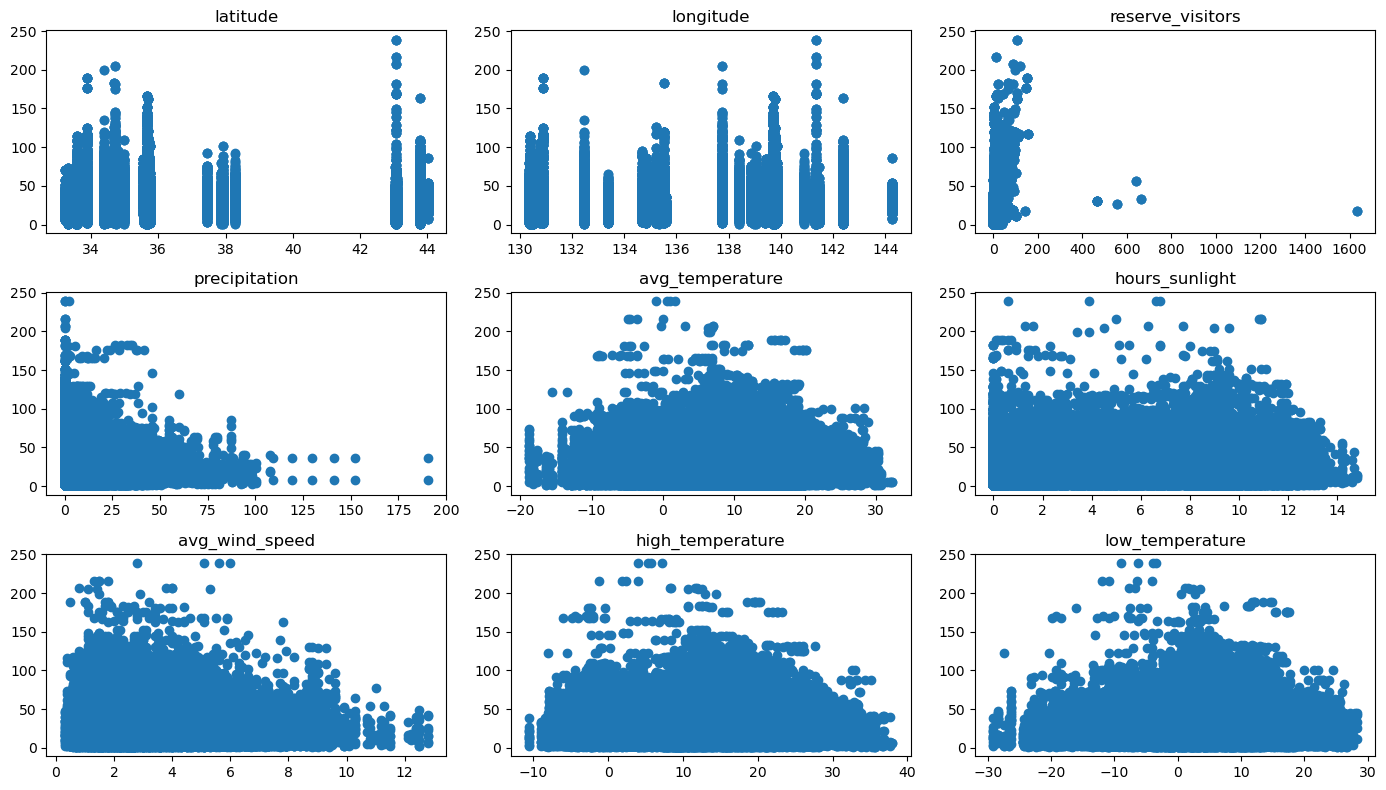

In [62]:
X_features_drop = X_features.drop(category_features, axis=1)
fig, axes = plt.subplots(3,3, figsize=(14,8))
column_list = list(X_features_drop.columns)

i = 0

for j in range(3):
    for k in range(3):
        axes[j,k].scatter(x = X_features_drop[column_list[i]], y = y_target)
        axes[j,k].set_title(column_list[i])
        i += 1
fig.tight_layout()
plt.show()

#### df = file_df 해놓기

In [63]:
df = file_df

In [64]:
#같은 지역, 같은 날짜, 다른 가게 > 전체 visitor 확인
print(df['area_name'].unique())
print(df['area_name'].nunique())

['Ōsaka-fu' 'Tōkyō-to' 'Hokkaidō' 'Shizuoka-ken' 'Hiroshima-ken'
 'Fukuoka-ken' 'Miyagi-ken' 'Hyōgo-ken' 'Niigata-ken']
9


In [65]:
df2 = pd.DataFrame(df.groupby(['area_name','visit_date','air_store_id'])['visitors'].sum())
df2

visitors
area_name   visit_date air_store_id                  
Fukuoka-ken 2016-01-02 air_789466e488705c93       476
            2016-01-03 air_6c91a28278a16f64       168
            2016-01-04 air_24b9b2a020826ede        77
                       air_2d3afcb91762fe01       469
                       air_622375b4815cf5cb       238
...                                               ...
Ōsaka-fu    2017-04-22 air_670a0c1c4108bcea       140
                       air_7420042ff75f9aca       260
                       air_c6a164dd4060e960        95
                       air_db4b38ebe7a7ceff        95
                       air_dea0655f96947922       320

[28064 rows x 1 columns]

In [66]:
df['area_name'].value_counts()

Tōkyō-to         88839
Fukuoka-ken      30674
Hokkaidō         13792
Ōsaka-fu         10195
Hyōgo-ken         9660
Shizuoka-ken      5481
Hiroshima-ken     4634
Niigata-ken       3075
Miyagi-ken         740
Name: area_name, dtype: int64

In [67]:
#가장 데이터가 많은 tokyo지역만 데이터 추출
df_tokyo = df[df['area_name'].str.contains('Tōkyō')]
df_tokyo.head()

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,high_temperature,low_temperature
5,air_877f79706adbfb06,2016-01-01,3,Japanese food,Tōkyō-to,35.658068,139.751599,3,Friday,1,0.0,NaN,NaN,NaN,NaN,NaN
6,air_877f79706adbfb06,2016-01-01,3,Japanese food,Tōkyō-to,35.658068,139.751599,3,Friday,1,0.0,NaN,NaN,NaN,NaN,NaN
7,air_877f79706adbfb06,2016-01-01,3,Japanese food,Tōkyō-to,35.658068,139.751599,3,Friday,1,0.0,5.4,9.2,3.0,11.1,0.4
8,air_877f79706adbfb06,2016-01-01,3,Japanese food,Tōkyō-to,35.658068,139.751599,3,Friday,1,0.0,7.9,9.4,2.7,12.7,4.8
9,air_877f79706adbfb06,2016-01-01,3,Japanese food,Tōkyō-to,35.658068,139.751599,3,Friday,1,0.0,5.9,9.1,1.0,12.6,-1.5


## **그래프 찍어보기**

In [68]:
#tokyo 중 가장 데이터가 많은 가게 찾기
df_tokyo.air_store_id.mode()

0    air_8093d0b565e9dbdf
Name: air_store_id, dtype: object

In [69]:
df_tokyo[df_tokyo.air_store_id == 'air_8093d0b565e9dbdf']

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,high_temperature,low_temperature
291,air_8093d0b565e9dbdf,2016-01-06,41,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,24,Wednesday,0,0.0,NaN,NaN,NaN,NaN,NaN
292,air_8093d0b565e9dbdf,2016-01-06,41,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,24,Wednesday,0,0.0,NaN,NaN,NaN,NaN,NaN
293,air_8093d0b565e9dbdf,2016-01-06,41,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,24,Wednesday,0,0.0,6.6,0.2,1.3,9.2,3.7
294,air_8093d0b565e9dbdf,2016-01-06,41,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,24,Wednesday,0,0.0,8.8,0.1,2.3,11.1,7.0
295,air_8093d0b565e9dbdf,2016-01-06,41,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,24,Wednesday,0,0.0,7.6,0.1,0.8,10.4,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166169,air_8093d0b565e9dbdf,2017-04-22,58,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,37,Saturday,0,17.5,13.5,0.1,1.2,17.5,9.3
166170,air_8093d0b565e9dbdf,2017-04-22,58,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,37,Saturday,0,9.0,14.8,NaN,4.2,17.7,11.1
166171,air_8093d0b565e9dbdf,2017-04-22,58,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,37,Saturday,0,14.5,13.9,0.0,1.3,17.7,9.9
166172,air_8093d0b565e9dbdf,2017-04-22,58,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,37,Saturday,0,15.5,NaN,NaN,NaN,NaN,NaN


nan drop X한 df의 tokyo 데이터는 2700개  
nan drop한 df의 tokyo 데이터는 1338개

In [134]:
test_tokyo = df_tokyo[df_tokyo.air_store_id == 'air_8093d0b565e9dbdf']
test_tokyo.head()

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,high_temperature,low_temperature
291,air_8093d0b565e9dbdf,2016-01-06,41,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,24,Wednesday,0,0.0,NaN,NaN,NaN,NaN,NaN
292,air_8093d0b565e9dbdf,2016-01-06,41,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,24,Wednesday,0,0.0,NaN,NaN,NaN,NaN,NaN
293,air_8093d0b565e9dbdf,2016-01-06,41,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,24,Wednesday,0,0.0,6.6,0.2,1.3,9.2,3.7
294,air_8093d0b565e9dbdf,2016-01-06,41,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,24,Wednesday,0,0.0,8.8,0.1,2.3,11.1,7.0
295,air_8093d0b565e9dbdf,2016-01-06,41,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,24,Wednesday,0,0.0,7.6,0.1,0.8,10.4,4.2


In [135]:
#각 column마다의 null 값을 일별 평균으로 채워넣기
fill_mean_func = lambda g: g.fillna(round(g.mean(),3))
test_tokyo = test_tokyo.groupby('visit_date').apply(fill_mean_func)

#일별로 groupby
test_tokyo = test_tokyo.groupby('visit_date').mean()
test_tokyo.head()

C:\Users\piai\AppData\Local\Temp\ipykernel_15752\219801329.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  fill_mean_func = lambda g: g.fillna(round(g.mean(),3))
C:\Users\piai\AppData\Local\Temp\ipykernel_15752\219801329.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  fill_mean_func = lambda g: g.fillna(round(g.mean(),3))
C:\Users\piai\AppData\Local\Temp\ipykernel_15752\219801329.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .grou

,visitors,latitude,longitude,reserve_visitors,holiday_flg,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,high_temperature,low_temperature
visit_date,,,,,,,,,,,
2016-01-06,41.0,35.672114,139.770825,24.0,0.0,0.0,8.216778,0.10,1.883222,10.533222,5.900000
2016-01-07,26.0,35.672114,139.770825,11.0,0.0,0.0,8.050000,6.06,2.633222,12.733222,3.583222
2016-01-08,44.0,35.672114,139.770825,22.0,0.0,0.0,6.100000,8.70,1.833222,10.400000,1.783222
2016-01-09,19.0,35.672114,139.770825,13.0,0.0,0.0,6.483222,8.90,2.216778,11.133222,1.533222
2016-01-10,26.0,35.672114,139.770825,24.0,0.0,0.0,7.333222,9.18,2.016778,12.933222,1.650000


### **heatmap으로 방문자 수에 대한 변수 영향력 관찰**

In [168]:
test_tokyo2 = test_tokyo.reset_index()

#visitors 구간만들기
bins = list(range(0, 80, 10))
bins_label = [str(x)+"이상 "+str(x+10)+"미만" for x in bins]
test_tokyo2['visitors_section'] = pd.cut(test_tokyo2['visitors'], bins, right=False, labels=bins_label[:-1])

test_tokyo2 = test_tokyo2.groupby('visitors_section').mean()
test_tokyo2

C:\Users\piai\AppData\Local\Temp\ipykernel_15752\3073515903.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_tokyo2 = test_tokyo2.groupby('visitors_section').mean()


,visitors,latitude,longitude,reserve_visitors,holiday_flg,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,high_temperature,low_temperature
visitors_section,,,,,,,,,,,
0이상 10미만,7.666667,35.672114,139.770825,4.333333,0.333333,0.000000,13.533222,5.973333,2.950000,18.588815,9.322148
10이상 20미만,14.837209,35.672114,139.770825,8.581395,0.069767,3.885173,9.748455,4.563721,3.013571,13.802724,6.196512
20이상 30미만,24.460317,35.672114,139.770825,16.079365,0.095238,3.959436,9.636513,5.549206,3.159540,14.253697,5.600277
30이상 40미만,34.894737,35.672114,139.770825,24.750000,0.013158,2.371436,9.742984,6.539474,3.117962,14.653947,5.223905
40이상 50미만,43.830986,35.672114,139.770825,29.647887,0.056338,1.910016,8.558919,6.079718,2.926283,13.223939,4.281454
50이상 60미만,54.500000,35.672114,139.770825,40.714286,0.000000,3.456841,9.811913,5.435714,2.993444,14.250599,5.675587
60이상 70미만,63.230769,35.672114,139.770825,45.846154,0.076923,0.675214,9.948709,6.607692,3.273077,15.357692,4.878162


In [173]:
test_tokyo3 = test_tokyo.reset_index()
test_tokyo3 = test_tokyo3.drop('visit_date', axis=1)

#각 column의 상관계수 구하기
test_tokyo3 = test_tokyo3.corr()

c:\Users\piai\anaconda3\envs\Jay\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
c:\Users\piai\anaconda3\envs\Jay\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


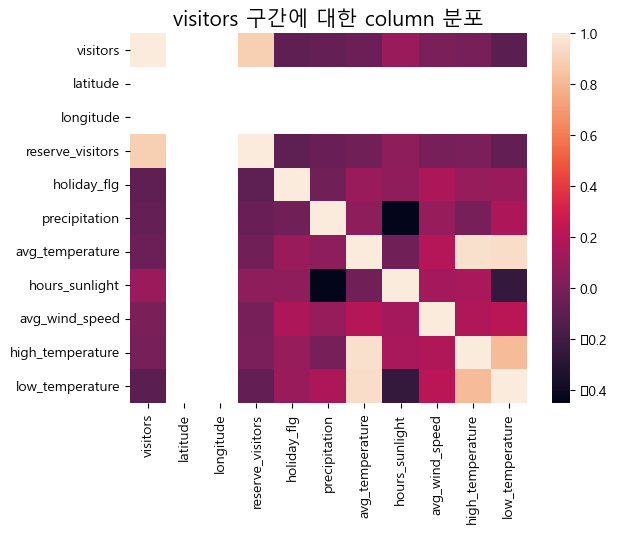

In [174]:
#heatmap
#그래프 깨짐방지
plt.rcParams['font.family'] = 'Malgun Gothic'

ax = sns.heatmap(test_tokyo3)
plt.title('visitors 구간에 대한 column 분포', fontsize=15)
plt.show()

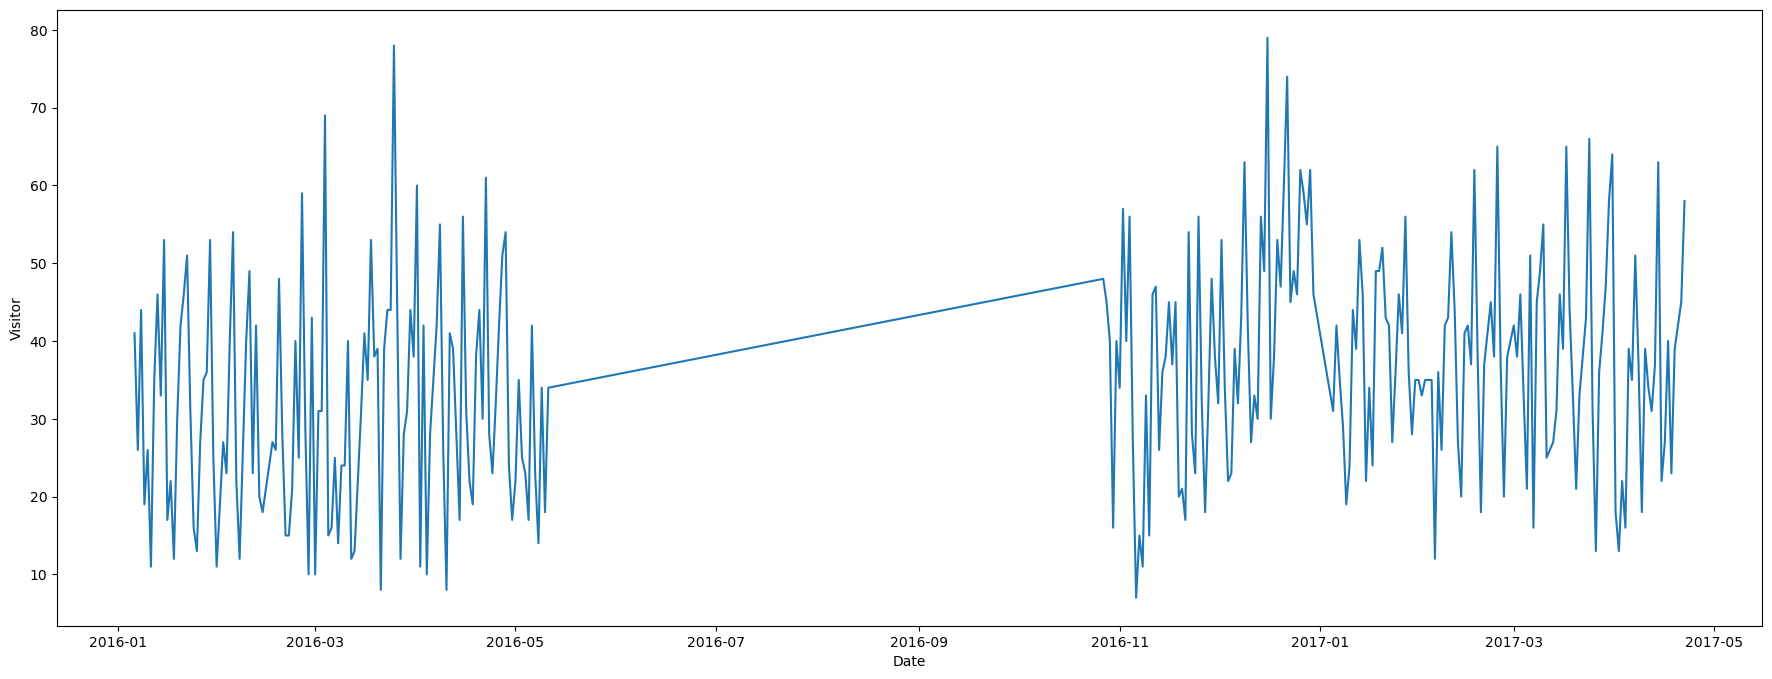

In [72]:
#시계열 그래프 찍어보기
#도쿄의 가게 하나의 방문자수 추이
plt.figure(figsize=(22,8))
plt.plot(test_tokyo.index, test_tokyo.visitors)
plt.xlabel("Date")
plt.ylabel("Visitor")
plt.show()

## **예측모델링**  

- 전처리 및 모델링 기타 참고 페이지  
1) https://data-analysis-expertise.tistory.com/67
2) https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346

#### **train, test 데이터**

In [73]:
def ts_train_test(test_tokyo, time_steps, for_periods):
    """
    input: 날짜를 인덱스로 가지는 데이터
    output: X_train, Y_train, 2016/1/6 ~ 2016/12/31
    X_test: 2017년 데이터

    time_steps: input데이터의 time steps (과거 며칠 데이터로)
    for_periods: output데이터의 time steps (미래 며칠동안 예측할건지)
    """
    #train, test set 만들기
    ts_train = test_tokyo[:'2016'].iloc[:,0:].values
    ts_test = test_tokyo['2017':].iloc[:,0:].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # #scale the data(데이터 정규화)
    # from sklearn.preprocessing import MinMaxScaler
    # sc = MinMaxScaler(feature_range=(0,1))
    # ts_train_scaled = sc.fit_transform(ts_train)

    #training 데이터의 samples와 time steps로 원본 데이터 슬라이싱하기
    X_train = []
    Y_train = []
    Y_train_stacked = []
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train[i-time_steps:i,0])
        Y_train.append(ts_train[i:i+for_periods,0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    
    #3차원으로 재구성하기: X_train
    #np.reshape(samples, time steps, features) 로 만듦
    # print(X_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    inputs = pd.concat((test_tokyo['visitors'][:'2016'], test_tokyo['visitors']['2017':]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = inputs.reshape(-1,1)
    # inputs = sc.transform(inputs)

    #Preparing to create X_test
    X_test=[]
    for i in range(time_steps, ts_test_len+time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i, 0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

    return X_train, Y_train, X_test

In [74]:
X_train, Y_train, X_test= ts_train_test(test_tokyo, 5, 2)

In [75]:
#3차원의 X_train을 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
Y_train_see = pd.DataFrame(Y_train)
train_see = pd.concat([X_train_see, Y_train_see], axis = 1)

#3차원의 X_test를 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
test_see = pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0])+" samples in the training data.")
print("There are " + str(X_test.shape[0])+" samples in the test data.")


There are 186 samples in the training data.
There are 106 samples in the test data.


In [76]:
train_see

,0,1,2,3,4,0,1
0,41.0,26.0,44.0,19.0,26.0,11.0,35.0
1,26.0,44.0,19.0,26.0,11.0,35.0,46.0
2,44.0,19.0,26.0,11.0,35.0,46.0,33.0
3,19.0,26.0,11.0,35.0,46.0,33.0,53.0
4,26.0,11.0,35.0,46.0,33.0,53.0,17.0
...,...,...,...,...,...,...,...
181,47.0,60.0,74.0,45.0,49.0,46.0,62.0
182,60.0,74.0,45.0,49.0,46.0,62.0,59.0
183,74.0,45.0,49.0,46.0,62.0,59.0,55.0
184,45.0,49.0,46.0,62.0,59.0,55.0,62.0


In [77]:
test_see

,0,1,2,3,4
0,62.0,59.0,55.0,62.0,46.0
1,59.0,55.0,62.0,46.0,31.0
2,55.0,62.0,46.0,31.0,42.0
3,62.0,46.0,31.0,42.0,35.0
4,46.0,31.0,42.0,35.0,29.0
...,...,...,...,...,...
101,34.0,31.0,37.0,63.0,22.0
102,31.0,37.0,63.0,22.0,27.0
103,37.0,63.0,22.0,27.0,40.0
104,63.0,22.0,27.0,40.0,23.0


우선 scaling 안하고 진행

#### **LSTM 모델 코드**

**LSTM**  
- units: 아웃풋 공간의 차원
- activation: 활성화함수, None을 전달하는 경우 활성화 적용안됨(선형적 활성화가 됨)
- recurrent_activation: 순환단계에서 사용할 활성화함수, default = hard_sigmoid
- return sequences: 불리언, 아웃풋 시퀀스의 마지막 아웃풋을 반환할지, 시퀀스 전체를 반환할지 선택

https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=lhk063&logNo=222042493275



In [78]:
def LSTM_model(X_train, Y_train, X_test):
    #필요 모듈 불러오기
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD

    #LSTM 아키텍처
    my_lstm = Sequential()
    my_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_lstm.add(LSTM(units=50, activation='tanh'))
    my_lstm.add(Dense(units=2))

    #컴파일링
    my_lstm.compile(optimizer='sgd', loss='mean_squared_error', metrics=['accuracy'])
    #(lr=0.01, decay=1e-7, momentum=0.9, nesterov = False), loss='mean_squared_error')

    #training data set에 피팅(fitting)
    from tensorflow.keras.callbacks import EarlyStopping
    earlystopper = EarlyStopping(monitor='accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
    my_lstm.fit(X_train, Y_train, epochs=100, batch_size=10, verbose=1, callbacks = [earlystopper])

    #X_test를 LSTM모델에 넣어서 예측하기
    LSTM_prediction =my_lstm.predict(X_test)

    return my_lstm, LSTM_prediction

In [79]:
my_lstm, LSTM_prediction = LSTM_model(X_train, Y_train, X_test)
LSTM_prediction[1:10]

Epoch 1/100
19/19 [==============================] - 3s 8ms/step - loss: 425.8669 - accuracy: 0.5591
Epoch 2/100
19/19 [==============================] - 0s 10ms/step - loss: 241.3439 - accuracy: 0.4946
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 230.0324 - accuracy: 0.5376
Epoch 4/100
19/19 [==============================] - 0s 8ms/step - loss: 235.3357 - accuracy: 0.5376
Epoch 5/100
19/19 [==============================] - 0s 8ms/step - loss: 233.6766 - accuracy: 0.5484
Epoch 6/100
19/19 [==============================] - 0s 8ms/step - loss: 230.4294 - accuracy: 0.4624
Epoch 7/100
19/19 [==============================] - 0s 8ms/step - loss: 236.2692 - accuracy: 0.5269
Epoch 8/100
19/19 [==============================] - 0s 8ms/step - loss: 235.9943 - accuracy: 0.4946
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping


array([[28.399872, 30.416304],
       [28.408308, 30.420328],
       [28.405544, 30.421171],
       [28.399672, 30.418585],
       [28.366785, 30.390123],
       [28.390076, 30.411875],
       [28.41312 , 30.425867],
       [28.40858 , 30.422447],
       [28.403786, 30.411127]], dtype=float32)

#### **LSTM 수행 결과 플롯 그리기 코드**

In [80]:
def actual_pred_plot(preds):
    """
    plot the actual vs prediction
    """

    actual_pred = pd.DataFrame(columns=['visitors', 'prediction'])
    actual_pred['visitors'] = test_tokyo.loc['2017':, 'visitors'][0:len(preds)]
    actual_pred['prediction'] = preds[:, 0]
    print(actual_pred)

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['visitors']), np.array(actual_pred['prediction']))

    return (m.result().numpy(), actual_pred.plot())

Epoch 1/100
19/19 [==============================] - 2s 8ms/step - loss: 424.6805 - accuracy: 0.4946
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 240.1624 - accuracy: 0.4516
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 238.9374 - accuracy: 0.4409
Epoch 4/100
19/19 [==============================] - 0s 8ms/step - loss: 234.9853 - accuracy: 0.5699
Epoch 5/100
19/19 [==============================] - 0s 8ms/step - loss: 237.9448 - accuracy: 0.5054
Epoch 6/100
19/19 [==============================] - 0s 8ms/step - loss: 236.9832 - accuracy: 0.5054
Epoch 7/100
19/19 [==============================] - 0s 7ms/step - loss: 239.0010 - accuracy: 0.4301
Epoch 8/100
19/19 [==============================] - 0s 8ms/step - loss: 234.1404 - accuracy: 0.4839
Epoch 9/100
19/19 [==============================] - 0s 8ms/step - loss: 234.3521 - accuracy: 0.5269
Epoch 10/100
19/19 [==============================] - 0s 8ms/step - loss: 236.4667 - accura

(156.04747, <AxesSubplot:xlabel='visit_date'>)

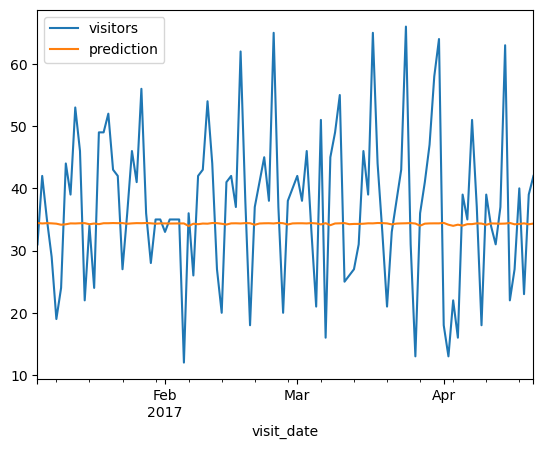

In [81]:
my_lstm, LSTM_prediction = LSTM_model(X_train, Y_train, X_test)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)

#### 데이터 scaling

In [177]:
def ts_train_test_normalize(test_tokyo,time_steps,for_periods):
    """
    input: 날짜를 인덱스로 가지는 데이터
    output: X_train, Y_train, 2016/1/6 ~ 2016/12/31
    X_test: 2017년 데이터

    time_steps: input데이터의 time steps (과거 며칠 데이터로)
    for_periods: output데이터의 time steps (미래 며칠동안 예측할건지)
    sc: insantiated MinMaxScaler object fit to the training data
    """

    # create training and test set
    ts_train = test_tokyo[:'2016'].iloc[:,0:1].values
    ts_test  = test_tokyo['2017':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    Y_train = []
    Y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train[i-time_steps:i,0])
        Y_train.append(ts_train[i:i+for_periods,0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((test_tokyo["visitors"][:'2016'], test_tokyo["visitors"]['2017':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)

    # Preparing X_test, Y_test
    X_test = []
    Y_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        Y_test.append(inputs[i:i+for_periods,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    Y_test = np.array(Y_test)

    return X_train, Y_train , X_test, Y_test, sc


In [178]:
X_train, Y_train, X_test, Y_test, sc= ts_train_test_normalize(test_tokyo, 5, 2)

In [179]:
#3차원의 X_train을 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
Y_train_see = pd.DataFrame(Y_train)
train_see = pd.concat([X_train_see, Y_train_see], axis = 1)

#3차원의 X_test를 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
Y_test_see = pd.DataFrame(Y_train)
testX_see = pd.DataFrame(X_test_see)
test_see = pd.concat([X_test_see, Y_test_see], axis = 1)

In [126]:
train_see

,0,1,2,3,4,0,1
0,0.472222,0.263889,0.513889,0.166667,0.263889,0.055556,0.388889
1,0.263889,0.513889,0.166667,0.263889,0.055556,0.388889,0.541667
2,0.513889,0.166667,0.263889,0.055556,0.388889,0.541667,0.361111
3,0.166667,0.263889,0.055556,0.388889,0.541667,0.361111,0.638889
4,0.263889,0.055556,0.388889,0.541667,0.361111,0.638889,0.138889
...,...,...,...,...,...,...,...
181,0.555556,0.736111,0.930556,0.527778,0.583333,0.541667,0.763889
182,0.736111,0.930556,0.527778,0.583333,0.541667,0.763889,0.722222
183,0.930556,0.527778,0.583333,0.541667,0.763889,0.722222,0.666667
184,0.527778,0.583333,0.541667,0.763889,0.722222,0.666667,0.763889


In [127]:
testX_see

,0,1,2,3,4
0,0.763889,0.722222,0.666667,0.763889,0.541667
1,0.722222,0.666667,0.763889,0.541667,0.333333
2,0.666667,0.763889,0.541667,0.333333,0.486111
3,0.763889,0.541667,0.333333,0.486111,0.388889
4,0.541667,0.333333,0.486111,0.388889,0.305556
...,...,...,...,...,...
101,0.375000,0.333333,0.416667,0.777778,0.208333
102,0.333333,0.416667,0.777778,0.208333,0.277778
103,0.416667,0.777778,0.208333,0.277778,0.458333
104,0.777778,0.208333,0.277778,0.458333,0.222222


In [128]:
test_see

,0,1,2,3,4,0,1
0,0.763889,0.722222,0.666667,0.763889,0.541667,0.055556,0.388889
1,0.722222,0.666667,0.763889,0.541667,0.333333,0.388889,0.541667
2,0.666667,0.763889,0.541667,0.333333,0.486111,0.541667,0.361111
3,0.763889,0.541667,0.333333,0.486111,0.388889,0.361111,0.638889
4,0.541667,0.333333,0.486111,0.388889,0.305556,0.638889,0.138889
...,...,...,...,...,...,...,...
181,NaN,NaN,NaN,NaN,NaN,0.541667,0.763889
182,NaN,NaN,NaN,NaN,NaN,0.763889,0.722222
183,NaN,NaN,NaN,NaN,NaN,0.722222,0.666667
184,NaN,NaN,NaN,NaN,NaN,0.666667,0.763889


#### **LSTM scale ver.**

In [92]:
def LSTM_model_regularization(X_train, Y_train, X_test, sc):
    #필요 모듈 불러오기
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
    from tensorflow.keras.optimizers import SGD
    from tensorflow.keras.optimizers import Adam

    #LSTM 아키텍처
    my_lstm = Sequential()
    my_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='softsign'))
    my_lstm.add(LSTM(units=50, activation='softsign'))
    my_lstm.add(Dropout(0.2))
    my_lstm.add(Dense(units=2))

    #컴파일링
    my_lstm.compile(optimizer=Adam(lr=0.01, decay=1e-7), loss='mean_squared_error', metrics=['accuracy'])
    #(lr=0.01, decay=1e-7, momentum=0.9, nesterov = False), loss='mean_squared_error')

    #training data set에 피팅(fitting)
    from tensorflow.keras.callbacks import EarlyStopping
    # earlystopper = EarlyStopping(monitor='accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
    my_lstm.fit(X_train, Y_train, epochs=50, batch_size=10, verbose=1)

    #X_test를 LSTM모델에 넣어서 예측하기
    LSTM_prediction =my_lstm.predict(X_test)

    #스케일러에 예측값을 넣어 반환하기
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_lstm, LSTM_prediction

Epoch 1/50


c:\Users\piai\anaconda3\envs\Jay\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


19/19 [==============================] - 3s 57ms/step - loss: 0.0594 - accuracy: 0.5215
Epoch 2/50
19/19 [==============================] - 1s 52ms/step - loss: 0.0474 - accuracy: 0.4946
Epoch 3/50
19/19 [==============================] - 1s 53ms/step - loss: 0.0462 - accuracy: 0.5484
Epoch 4/50
19/19 [==============================] - 1s 52ms/step - loss: 0.0476 - accuracy: 0.5484
Epoch 5/50
19/19 [==============================] - 1s 52ms/step - loss: 0.0467 - accuracy: 0.5161
Epoch 6/50
19/19 [==============================] - 1s 53ms/step - loss: 0.0448 - accuracy: 0.5215
Epoch 7/50
19/19 [==============================] - 1s 52ms/step - loss: 0.0451 - accuracy: 0.4516
Epoch 8/50
19/19 [==============================] - 1s 51ms/step - loss: 0.0478 - accuracy: 0.5860
Epoch 9/50
19/19 [==============================] - 1s 52ms/step - loss: 0.0468 - accuracy: 0.5000
Epoch 10/50
19/19 [==============================] - 1s 53ms/step - loss: 0.0460 - accuracy: 0.4570
Epoch 11/50
19/19 [=

(175.41374, <AxesSubplot:xlabel='visit_date'>)

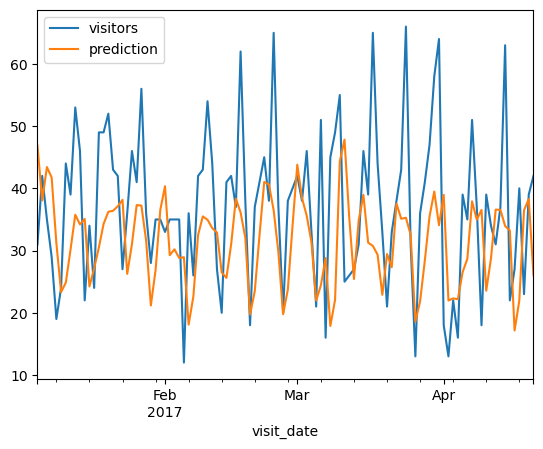

In [93]:
my_lstm, LSTM_prediction = LSTM_model_regularization(X_train, Y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)

In [129]:
#모델 정확도 출력하기
loss_and_accuracy = my_lstm.evaluate(X_test, Y_test)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0], loss_and_accuracy[1]))

4/4 [==============================] - 0s 10ms/step - loss: 0.0336 - accuracy: 0.5943
loss : 0.0336, accruracy : 0.5943


In [145]:
### **confusion matrix**
#confustion matrix
# Pandas를 활용하여 confusion matrix 만들기
Y_test_list = []
LSTM_prediction_list = []
for i in Y_test:
    Y_test_list.append(i[0])

for j in LSTM_prediction:
    LSTM_prediction_list.append(j[0])


data = {'Real' : Y_test_list, 'Predict' : LSTM_prediction_list}
df = pd.DataFrame(data, columns=['Real','Predict'])
conf_mat = pd.crosstab(df['Real'], df['Predict'], rownames=['Real'], colnames=['Predict'])
print(conf_mat)

Predict   17.165564  17.885368  18.103706  18.564505  19.730133  19.775454  \
Real                                                                         
0.069444          0          0          0          0          0          0   
0.083333          0          0          0          1          0          0   
0.125000          0          0          0          0          0          0   
0.152778          0          0          0          0          1          0   
0.166667          0          0          0          0          0          0   
0.180556          0          0          0          0          0          1   
0.194444          0          0          0          0          0          0   
0.208333          0          0          0          0          0          0   
0.222222          0          0          0          0          0          0   
0.236111          0          0          0          0          0          0   
0.250000          0          0          0          0          0 

### **GRU 모델코드**

c:\Users\piai\anaconda3\envs\Jay\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
19/19 [==============================] - 5s 16ms/step - loss: 0.0746 - accuracy: 0.4462
Epoch 2/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0480 - accuracy: 0.5000
Epoch 3/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0492 - accuracy: 0.4785
Epoch 4/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0487 - accuracy: 0.5161
Epoch 5/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0467 - accuracy: 0.4946
Epoch 6/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0477 - accuracy: 0.4946
Epoch 7/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0485 - accuracy: 0.5108
Epoch 8/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0465 - accuracy: 0.5054
Epoch 9/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0491 - accuracy: 0.4624
Epoch 10/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0462 - accuracy: 0.5215
Epoch 11/

(165.91753, <AxesSubplot:xlabel='visit_date'>)

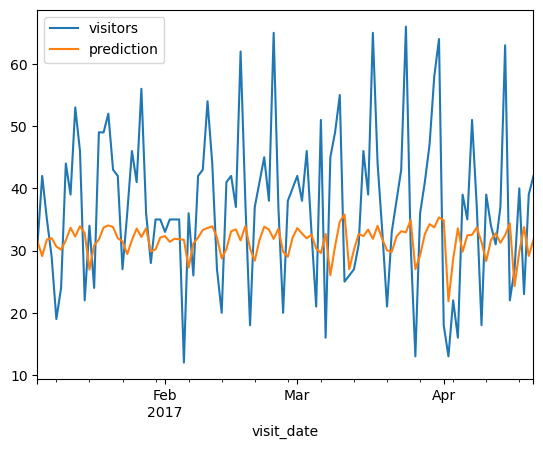

In [90]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
    from tensorflow.keras.optimizers import SGD
    from tensorflow.keras.optimizers import Adam
    
    # GRU 구조
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units=2))

    # 컴파일링
    my_GRU_model.compile(optimizer=Adam(lr=0.01, decay=1e-7), loss='mean_squared_error', metrics=['accuracy'])
    # Fitting to the training set
    my_GRU_model.fit(X_train,Y_train,epochs=50,batch_size=10, verbose=1)

    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return my_GRU_model, GRU_prediction

my_GRU_model, GRU_prediction = GRU_model(X_train,Y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction) 

In [130]:
#모델 정확도 출력하기
loss_and_accuracy = my_GRU_model.evaluate(X_test, Y_test)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0], loss_and_accuracy[1]))

4/4 [==============================] - 1s 9ms/step - loss: 0.0302 - accuracy: 0.5283
loss : 0.0302, accruracy : 0.5283


### **GRU 고도화**

c:\Users\piai\anaconda3\envs\Jay\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
19/19 [==============================] - 3s 8ms/step - loss: 0.0681 - accuracy: 0.4570
Epoch 2/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0498 - accuracy: 0.4892
Epoch 3/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0496 - accuracy: 0.5269
Epoch 4/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0491 - accuracy: 0.5430
Epoch 5/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0491 - accuracy: 0.5376
Epoch 6/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0453 - accuracy: 0.5645
Epoch 7/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0467 - accuracy: 0.5215
Epoch 8/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0460 - accuracy: 0.5430
Epoch 9/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0450 - accuracy: 0.5538
Epoch 10/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0445 - accuracy: 0.5323
Epoch 11/50
19/19 [

(197.8866, <AxesSubplot:xlabel='visit_date'>)

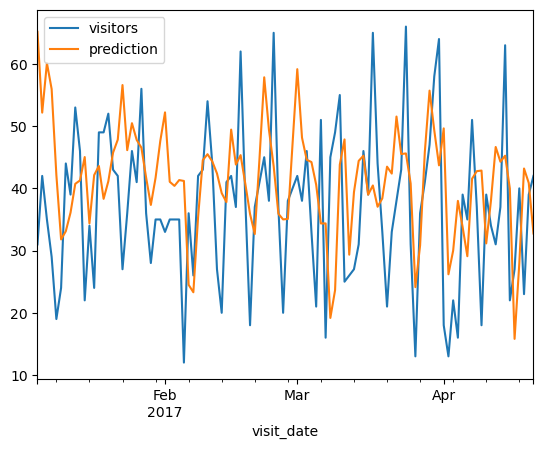

In [91]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
    from tensorflow.keras.optimizers import SGD
    from tensorflow.keras.optimizers import Adam
    
    # GRU 구조
    my_GRU_model2 = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # my_GRU_model2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # my_GRU_model2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model2.add(GRU(units=50, activation='tanh'))
    my_GRU_model2.add(Dropout(0.2))
    my_GRU_model2.add(Dense(units=2))

    # 컴파일링
    my_GRU_model2.compile(optimizer=Adam(lr=0.01, decay=1e-7), loss='mean_squared_error', metrics=['accuracy'])
    # Fitting to the training set
    from tensorflow.keras.callbacks import EarlyStopping
    earlystopper = EarlyStopping(monitor='accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
    my_GRU_model2.fit(X_train,Y_train,epochs=50,batch_size=10, verbose=1)

    GRU_prediction = my_GRU_model2.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return my_GRU_model2, GRU_prediction

my_GRU_model2, GRU_prediction = GRU_model(X_train,Y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction) 

In [131]:
#모델 정확도 출력하기
loss_and_accuracy = my_GRU_model2.evaluate(X_test, Y_test)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0], loss_and_accuracy[1]))

4/4 [==============================] - 1s 6ms/step - loss: 0.0340 - accuracy: 0.5943
loss : 0.0340, accruracy : 0.5943


tanh대신 softsign 사용

Epoch 1/50
19/19 [==============================] - 4s 72ms/step - loss: 0.0665 - accuracy: 0.5645
Epoch 2/50
19/19 [==============================] - 1s 69ms/step - loss: 0.0516 - accuracy: 0.5645
Epoch 3/50
19/19 [==============================] - 1s 69ms/step - loss: 0.0504 - accuracy: 0.5000
Epoch 4/50
19/19 [==============================] - 1s 69ms/step - loss: 0.0462 - accuracy: 0.5376
Epoch 5/50
19/19 [==============================] - 1s 67ms/step - loss: 0.0431 - accuracy: 0.5914
Epoch 6/50
19/19 [==============================] - 1s 69ms/step - loss: 0.0467 - accuracy: 0.5484
Epoch 7/50
19/19 [==============================] - 1s 68ms/step - loss: 0.0450 - accuracy: 0.5161
Epoch 8/50
19/19 [==============================] - 1s 69ms/step - loss: 0.0439 - accuracy: 0.5376
Epoch 9/50
19/19 [==============================] - 1s 69ms/step - loss: 0.0463 - accuracy: 0.5699
Epoch 10/50
19/19 [==============================] - 1s 68ms/step - loss: 0.0445 - accuracy: 0.4785
Epoch 11/

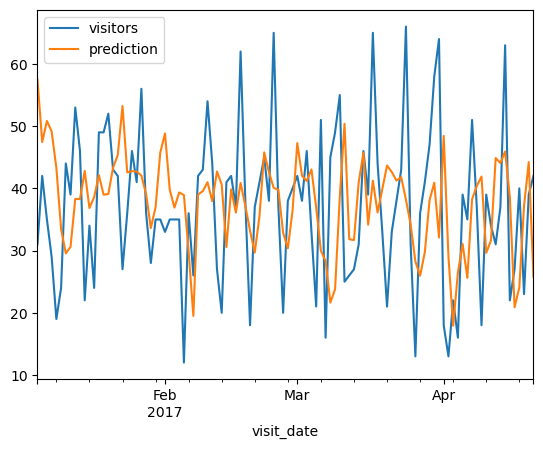

In [133]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
    from tensorflow.keras.optimizers import SGD
    from tensorflow.keras.optimizers import Adam
    
    # GRU 구조
    my_GRU_model2 = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='softsign'))
    # my_GRU_model2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='softsign'))
    # my_GRU_model2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='softsign'))
    my_GRU_model2.add(GRU(units=50, activation='softsign'))
    my_GRU_model2.add(Dropout(0.2))
    my_GRU_model2.add(Dense(units=2))

    # 컴파일링
    my_GRU_model2.compile(optimizer=Adam(lr=0.01, decay=1e-7), loss='mean_squared_error', metrics=['accuracy'])
    # Fitting to the training set
    from tensorflow.keras.callbacks import EarlyStopping
    earlystopper = EarlyStopping(monitor='accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
    my_GRU_model2.fit(X_train,Y_train,epochs=50,batch_size=10, verbose=1)

    GRU_prediction = my_GRU_model2.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return my_GRU_model2, GRU_prediction

my_GRU_model2, GRU_prediction = GRU_model(X_train,Y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

#모델 정확도 출력하기
loss_and_accuracy = my_GRU_model2.evaluate(X_test, Y_test)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0], loss_and_accuracy[1]))